In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm


In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Layer and models

In [24]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.in_dim, self.in_dim))
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.srqt(5))
        
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, bias=False):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.bias = bias
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim, self.bias)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        #weight init
        self.lin_ode.weight.data.uniform_(-0.1,0.1)
        if self.bias:
            self.lin_ode.bias.data.uniform_(-0.1,0.1)
        self.nl_ode.weight.data.uniform_(-0.01,0.01)
            
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

In [4]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss

# Training Pendulum with Linear ODE Model

In [5]:
kk = 0.01
AA = np.asarray([[1,1],[-kk,1]])

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([100, 2])
train_y.shape: torch.Size([100, 2])


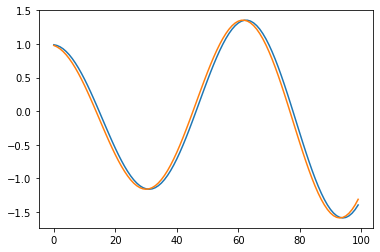

In [57]:
plt.plot(train_x[:,0].numpy());
plt.plot(train_y[:,0].numpy())
plt.show()

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4557,  0.6042],
        [-0.6894,  0.4489]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9977,  0.9983],
        [-0.0100,  1.0000]], requires_grad=True)]


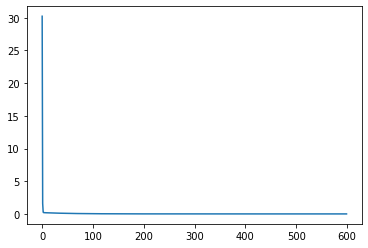

In [7]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

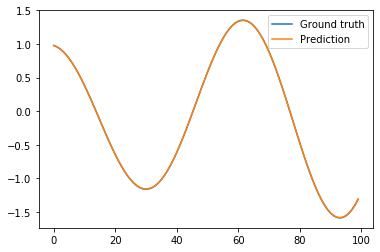

In [12]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

# Training pendulum with batches of 10

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4757,  0.5248],
        [-0.1768, -0.5596]], requires_grad=True)]
Epoch: 1 train_loss: 102.88022770360112
weight:
[Parameter containing:
tensor([[ 0.5347,  0.6301],
        [-0.0437,  0.9730]], requires_grad=True)]
Epoch: 11 train_loss: 0.3133137070108205
weight:
[Parameter containing:
tensor([[ 0.8438,  0.8759],
        [-0.0213,  0.9910]], requires_grad=True)]
Epoch: 21 train_loss: 0.035281848948216066
weight:
[Parameter containing:
tensor([[ 0.9476,  0.9583],
        [-0.0138,  0.9970]], requires_grad=True)]
Epoch: 31 train_loss: 0.003973013390350388
weight:
[Parameter containing:
tensor([[ 0.9824,  0.9860],
        [-0.0113,  0.9990]], requires_grad=True)]
Epoch: 41 train_loss: 0.00044737051666743355
weight:
[Parameter containing:
tensor([[ 0.9941,  0.9953],
        [-0.0104,  0.9997]], requires_grad=True)]
Epoch: 51 train_loss: 5.0373351314192405e-05
weight:

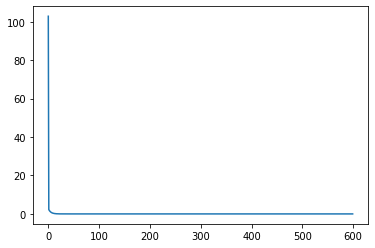

In [63]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 10)
    train_loss.append(loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

# Training pendulum with bias

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.6144,  0.5536],
        [ 0.1536, -0.4627]], requires_grad=True), Parameter containing:
tensor([-0.5922,  0.0529], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9899,  0.9979],
        [-0.0098,  1.0000]], requires_grad=True), Parameter containing:
tensor([-0.0072, -0.0008], requires_grad=True)]


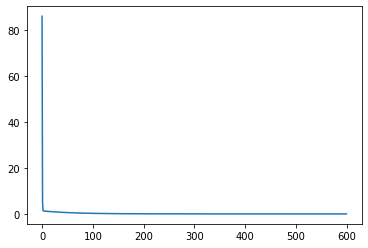

In [109]:
#with bias
model = LinearODEModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0682, -0.3525],
        [-0.5972, -0.5977]], requires_grad=True), Parameter containing:
tensor([ 0.6563, -0.0023], requires_grad=True)]
Epoch: 1 train_loss: 135.5758940577507
weight:
[Parameter containing:
tensor([[ 0.0615, -0.1556],
        [-0.0964,  0.9100]], requires_grad=True), Parameter containing:
tensor([0.6530, 0.1546], requires_grad=True)]
Epoch: 11 train_loss: 2.3525771657004952
weight:
[Parameter containing:
tensor([[ 0.6877,  0.6143],
        [-0.0399,  0.9708]], requires_grad=True), Parameter containing:
tensor([0.2628, 0.0234], requires_grad=True)]
Epoch: 21 train_loss: 0.2898701975354925
weight:
[Parameter containing:
tensor([[ 0.8961,  0.8712],
        [-0.0205,  0.9906]], requires_grad=True), Parameter containing:
tensor([ 0.1085, -0.0052], requires_grad=True)]
Epoch: 31 train_loss: 0.038187254293006845
weight:
[Parameter containing:
tensor([[ 0

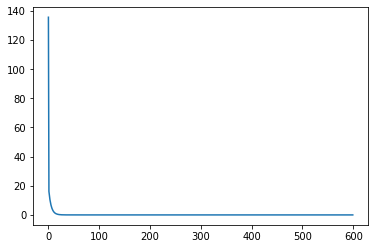

In [64]:
#with bias
model = LinearODEModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 10)
    train_loss.append(loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

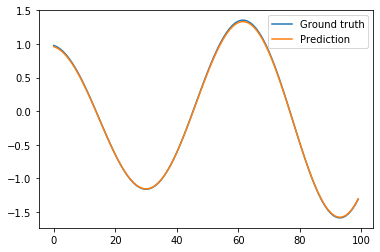

In [110]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

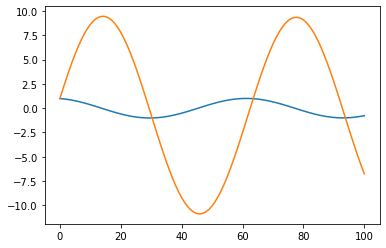

In [128]:
Atest = np.asarray([[0.9899,0.9979],[-0.0098,1.0000]])
btest = np.asarray([-0.0072, -0.0008])

soltest = [[0.99,1]]

for i in range(100):
    soltest.append(np.dot(np.asarray(soltest[-1]),Atest) + btest)
    
Xtest = np.asarray(soltest)
plt.plot(Xtest)
plt.show()

# Training pendulum with Non Linear model

In [47]:
dt = 1
kk = 0.01
A = np.asarray([[0,1],[-kk,0]])

I = np.eye(2)
AA = (I + dt*A)

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

Initial matrix A:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0989,  0.0438],
        [-0.0253, -0.0547]], requires_grad=True), Parameter containing:
tensor([[[ 5.0280e-04, -3.2501e-04],
         [-6.4196e-05, -6.5477e-04]],

        [[-5.7355e-04, -5.2367e-04],
         [ 4.6625e-04,  1.0469e-04]]], requires_grad=True)]



Epoch: 1 train_loss: 3111.855749517679
weight:
[Parameter containing:
tensor([[ 0.0182,  0.1380],
        [-0.0631,  0.1487]], requires_grad=True), Parameter containing:
tensor([[[-0.0312,  0.0018],
         [ 0.0021, -0.0163]],

        [[ 0.0097,  0.0163],
         [ 0.0173,  0.0369]]], requires_grad=True)]



Epoch: 2 train_loss: 2467.05778875947
weight:
[Parameter containing:
tensor([[ 0.0777,  0.1562],
        [-0.0534,  0.2048]], requires_grad=True), Parameter containing:
tensor([[[-0.0405,  0.0045],
         [ 0.0047, -0.0100]],

        [[ 0.0028,  0.0115],
         [ 0.0125,  0.0318]]], requires_grad=True

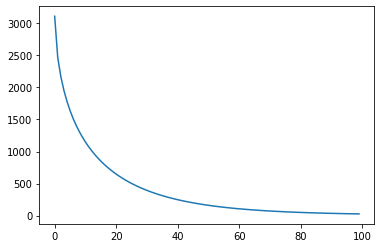

In [99]:
print('Initial matrix A:')
print(AA)


model = NNODEModel(2,2,2)
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(100):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 1)
    train_loss.append(loss)
    print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
    print('weight:')
    print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

# Training Lorenz attractor with Non Linear ODE model

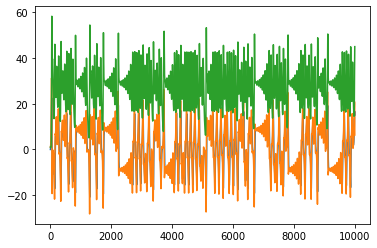

In [39]:
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01

sol = [[x, y, z]]
for i in range(10000):
    f = x + (sigma*(y - x))*dt
    g = y + (rho*x - x*z - y)*dt
    h = z + (x*y - beta*z)*dt
    sol.append([f,g,h])
    x = f
    y = g
    z = h


plt.plot(sol)
plt.show()

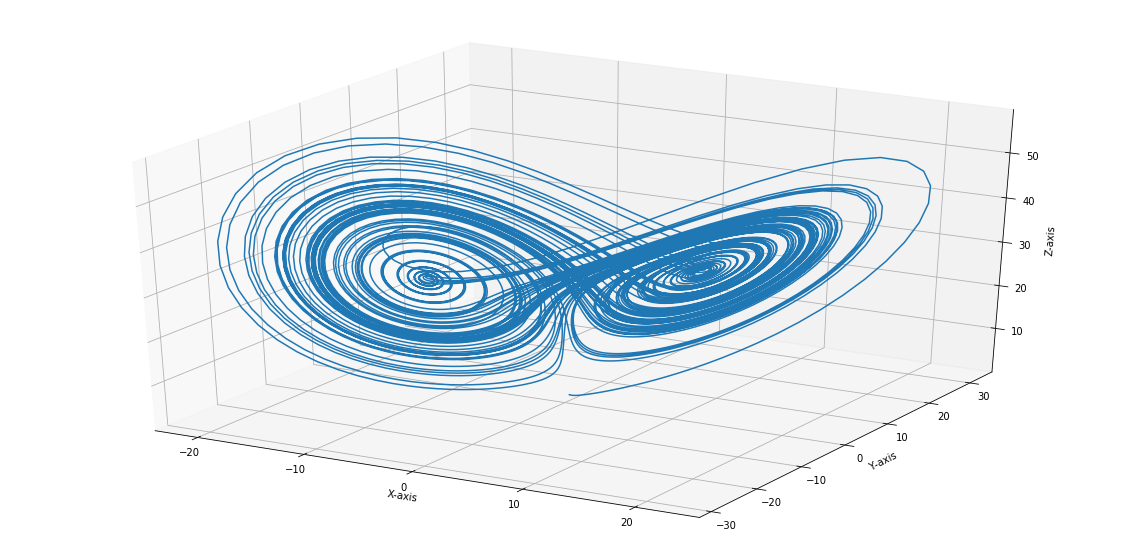

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(np.array(sol)[:,0], np.array(sol)[:,1], np.array(sol)[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [5]:
#small modification
sigma = 10
rho = 28
beta = 2.67

dt = 0.01

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt

B = np.array([Q0, Q1, Q2])

I = np.eye(3)
AA = (I+dt*A)


sol = [[ 0., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    Ax = AA.dot(x)
    
    phix = x.T.dot(B).dot(x)
    
    f = Ax + phix
    sol.append(f)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([10000, 3])
train_y.shape: torch.Size([10000, 3])


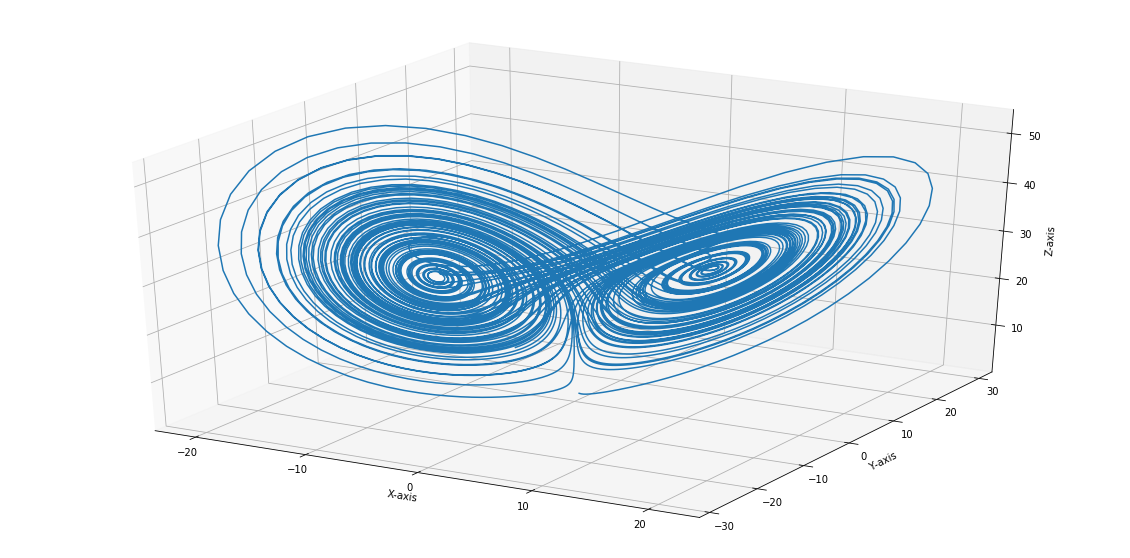

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

IReal matrix A:
[[0.9    0.1    0.    ]
 [0.28   0.99   0.    ]
 [0.     0.     0.9733]]
Real matrix B:
[[[ 0.    0.    0.  ]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]

 [[ 0.    0.   -0.01]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]

 [[ 0.    0.01  0.  ]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0230,  0.0191,  0.0996],
        [ 0.0497, -0.0957,  0.0504],
        [-0.0370,  0.0695, -0.0568]], requires_grad=True), Parameter containing:
tensor([[[ 0.0100,  0.0017,  0.0035],
         [ 0.0040,  0.0066, -0.0013],
         [ 0.0031,  0.0007,  0.0069]],

        [[-0.0023,  0.0012, -0.0011],
         [ 0.0066, -0.0071, -0.0026],
         [ 0.0046, -0.0083,  0.0029]],

        [[ 0.0028,  0.0020,  0.0089],
         [ 0.0092,  0.0004,  0.0071],
         [-0.0020, -0.0045, -0.0051]]], requires_grad=True)]



Epoch: 1 train_loss: 2875.3214297294617
weight:
[Parameter containing:
tensor([[ 0.0112,  0.0697,  0.0942],
   

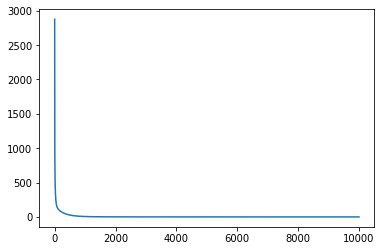

In [18]:
print('IReal matrix A:')
print(AA)
print('Real matrix B:')
print(B)


model = NNODEModel(3,3,3)
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(10000):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 100)
    train_loss.append(loss)
    if epoch%1000 == 0:
        print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

IReal matrix A:
[[0.9    0.1    0.    ]
 [0.28   0.99   0.    ]
 [0.     0.     0.9733]]
Real matrix B:
[[[ 0.    0.    0.  ]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]

 [[ 0.    0.   -0.01]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]

 [[ 0.    0.01  0.  ]
  [ 0.    0.    0.  ]
  [ 0.    0.    0.  ]]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.0013,  0.0457, -0.0961],
        [ 0.0537,  0.0825,  0.0002],
        [-0.0600,  0.0075,  0.0496]], requires_grad=True), Parameter containing:
tensor([-0.0934,  0.0175, -0.0200], requires_grad=True), Parameter containing:
tensor([[[-0.0031, -0.0040, -0.0066],
         [-0.0053,  0.0098, -0.0057],
         [-0.0089, -0.0087,  0.0094]],

        [[ 0.0023,  0.0052,  0.0032],
         [-0.0010,  0.0089, -0.0010],
         [ 0.0083, -0.0056, -0.0013]],

        [[-0.0093, -0.0068,  0.0095],
         [-0.0025, -0.0037,  0.0020],
         [-0.0095, -0.0092,  0.0097]]], requires_grad=True)]



Epoch: 1 train_loss: 1726.433824

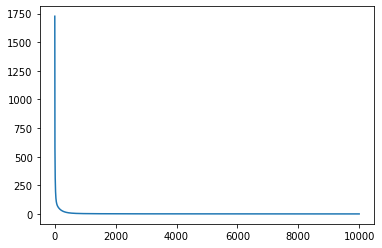

In [25]:
print('IReal matrix A:')
print(AA)
print('Real matrix B:')
print(B)


model = NNODEModel(3,3,3, True)
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(10000):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 100)
    train_loss.append(loss)
    if epoch%1000 == 0:
        print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()